In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from experiments.evaluation.loading import load

/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
reload = False

# Normal distribution
folders_eval = [
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-11-03/12-29-52/",  # hidden, visible_changing
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-11-03/19-59-39",  # visibile_all, cgate_hadamard, cgate_lstm
]

# Uniform distribution
folders_eval = [
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-11-07/20-45-00"  # all visibilities
]

# sac, small hadamard
folders_eval = [
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-11-13/22-44-20"
]

# rerun
folders_eval = [
    # "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/runs/contextefficiency_hidden/context_efficiency/CARLPendulumEnv/eval/on_test"
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/runs/context_efficiency/CARLPendulumEnv/eval/on_test"
]


df = pd.concat([load(folder_eval=folder_eval, rpc_fn=f"tmp/rpc_context_efficiency_{i}.csv", reload_rpc=reload) for i, folder_eval in enumerate(folders_eval)]).reset_index(drop=True)
# df = df[df["n_contexts"] < 256]
df["n_contexts_log"] = df["n_contexts"].apply(lambda x: np.log(x)/np.log(2))  # n_contexts are 1,2,4,8,16,... power of 2
df = df[(df["visibility"] == "hidden") | (df["visibility"] == "concat (non-static)") | (df["visibility"] == "cgate_hadamard")]

In [3]:
print(df.columns)
df.describe()

Index(['context_id', 'return', 'dt', 'g', 'initial_angle_max',
       'initial_velocity_max', 'l', 'm', 'max_speed', 'seed', 'visibility',
       'n_contexts', 'rep', 'n_contexts_log'],
      dtype='object')


,context_id,return,dt,g,initial_angle_max,initial_velocity_max,l,m,max_speed,seed,n_contexts,rep,n_contexts_log
count,5.089280e+06,5.089280e+06,5.089280e+06,5089280.0,5.089280e+06,5089280.0,5.089280e+06,5089280.0,5089280.0,5.089280e+06,5.089280e+06,5.089280e+06,5.089280e+06
mean,5.115000e+02,-9.906584e+02,5.000000e-02,10.0,3.141593e+00,1.0,9.978660e-01,1.0,8.0,5.490946e+00,1.026117e+02,4.500000e+00,4.498994e+00
std,2.956032e+02,6.431724e+02,4.857226e-16,0.0,4.440893e-14,0.0,2.912747e-01,0.0,0.0,2.859630e+00,1.568462e+02,2.872282e+00,2.877880e+00
min,0.000000e+00,-1.970299e+03,5.000000e-02,10.0,3.141593e+00,1.0,5.012331e-01,1.0,8.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.557500e+02,-1.568843e+03,5.000000e-02,10.0,3.141593e+00,1.0,7.409349e-01,1.0,8.0,3.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00
50%,5.115000e+02,-1.226609e+03,5.000000e-02,10.0,3.141593e+00,1.0,9.948241e-01,1.0,8.0,5.000000e+00,3.200000e+01,4.500000e+00,5.000000e+00
75%,7.672500e+02,-2.303427e+02,5.000000e-02,10.0,3.141593e+00,1.0,1.258447e+00,1.0,8.0,8.000000e+00,1.280000e+02,7.000000e+00,7.000000e+00
max,1.023000e+03,-1.303387e-04,5.000000e-02,10.0,3.141593e+00,1.0,1.499105e+00,1.0,8.0,1.000000e+01,5.120000e+02,9.000000e+00,9.000000e+00


/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/seaborn/axisgrid.py:181: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


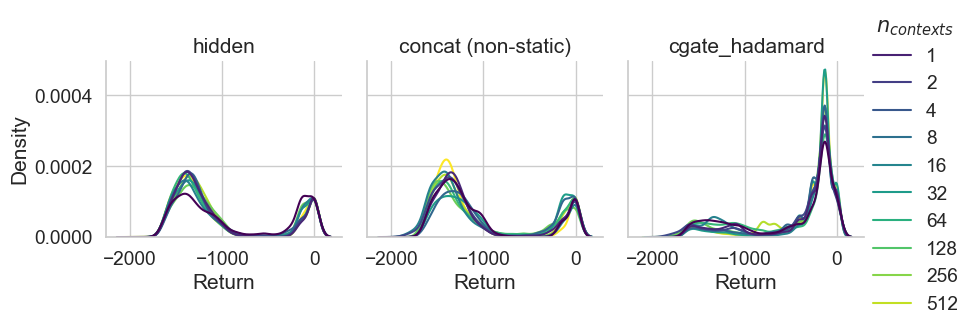

tmp/figures/context_efficiency/col_visibility_hue_ncontexts.png

/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/seaborn/axisgrid.py:181: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


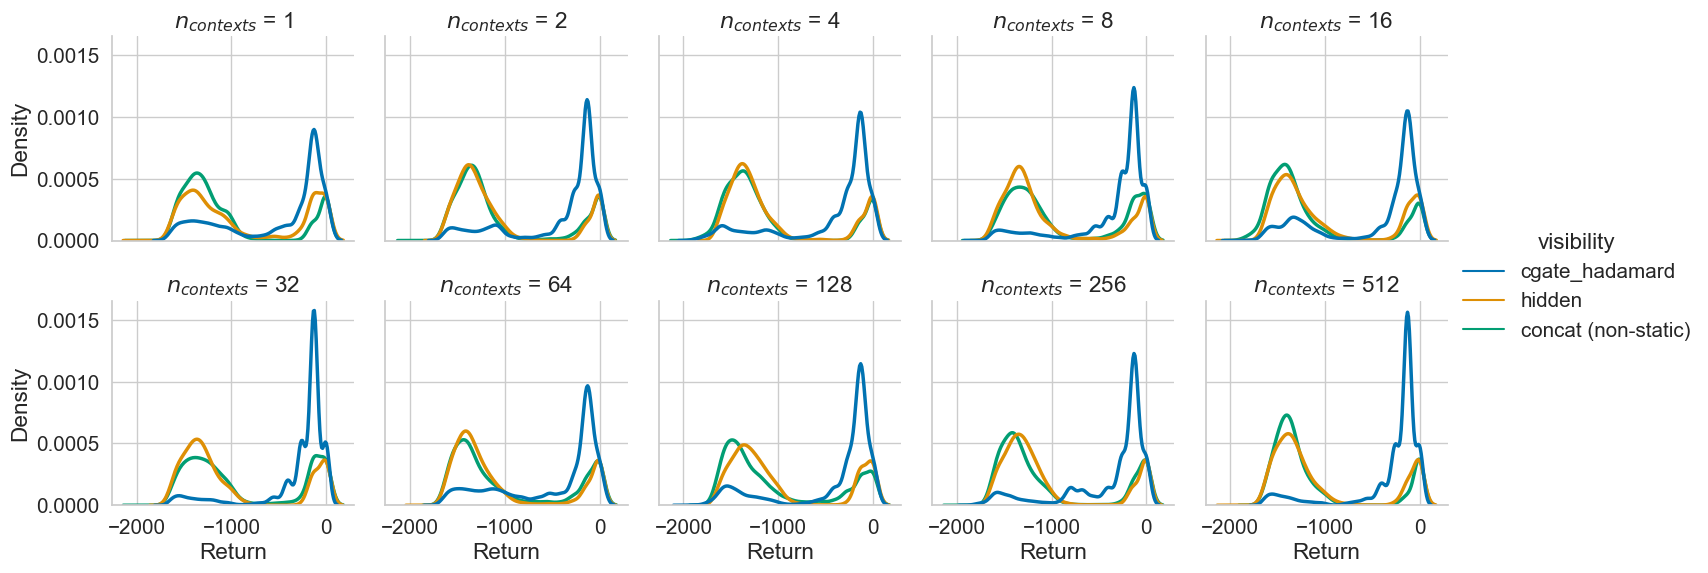

tmp/figures/context_efficiency/col_ncontexts_hue_visibility.png

In [4]:
from pathlib import Path
from matplotlib.lines import Line2D
from rich import print as printr

sns.set(font_scale=1.25)
sns.set_style("whitegrid")


def get_legend_handles(df, hue, palette="colorblind", labeltype: str | None = None):
    hues = df[hue].unique()
    palette = sns.color_palette(palette=palette, n_colors=len(hues))
    palette = {n: c for n, c in zip(hues, palette)}
    labelfn = lambda n: f"{int(2**int(n))}" if labeltype == "n_contexts" else n
    handles = [Line2D([0], [0], color=c, label=labelfn(n)) for n, c in palette.items()]
    return handles

col_order = ["hidden", "concat (all)", "concat (non-static)", "cgate_hadamard", "cgate_lstm"]
col_order = ["hidden", "concat (non-static)", "cgate_hadamard"]

fig_fn = Path("tmp/figures/context_efficiency/col_visibility_hue_ncontexts.png")
fig_fn.parent.mkdir(exist_ok=True, parents=True)
col = "visibility"
hue = "n_contexts_log"
palette = "viridis"
handles = get_legend_handles(df=df, hue=hue, palette=palette, labeltype="n_contexts")
grid = sns.FacetGrid(data=df, col=col, legend_out=True, col_order=col_order)
grid = grid.map_dataframe(sns.kdeplot, x="return", hue=hue, palette=palette)
grid = grid.add_legend(handles=handles, title="$n_{contexts}$")
grid.set_xlabels("Return")
grid.set_titles(col_template="{col_name}")
# grid.figure.set_tight_layout(True)
grid.figure.savefig(fig_fn, dpi=300, bbox_inches="tight")
plt.show()
printr(fig_fn)

sns.set(font_scale=1.35)
sns.set_style("whitegrid")
fig_fn = Path("tmp/figures/context_efficiency/col_ncontexts_hue_visibility.png")
fig_fn.parent.mkdir(exist_ok=True, parents=True)
col = "n_contexts"
hue = "visibility"
palette = "colorblind"
handles = get_legend_handles(df=df, hue=hue, palette=palette)
grid = sns.FacetGrid(data=df, col=col, legend_out=True, col_wrap=5)
grid = grid.map_dataframe(sns.kdeplot, x="return", hue=hue, palette=palette, lw=2.5)
grid = grid.add_legend(handles=handles, title=hue)
grid.set_titles(col_template="$n_{{contexts}}$ = {col_name}")
grid.set_xlabels("Return")
# grid.figure.set_tight_layout(True)
grid.figure.savefig(fig_fn, dpi=300, bbox_inches="tight")
plt.show()
printr(fig_fn)


# fig_fn = Path("tmp/figures/context_efficiency/row_ncontexts_col_visibility.png")
# fig_fn.parent.mkdir(exist_ok=True, parents=True)
# row = "n_contexts_log"
# col = "visibility"
# palette = "colorblind"
# handles = get_legend_handles(df=df, hue=hue, palette=palette)
# grid = sns.FacetGrid(data=df, col=col, row=row, legend_out=True)
# grid = grid.map_dataframe(sns.kdeplot, x="return")
# # grid = grid.add_legend(handles=handles, title=hue)
# grid.figure.set_tight_layout(True)
# grid.figure.savefig(fig_fn, dpi=300, bbox_inches="tight")
# plt.show()



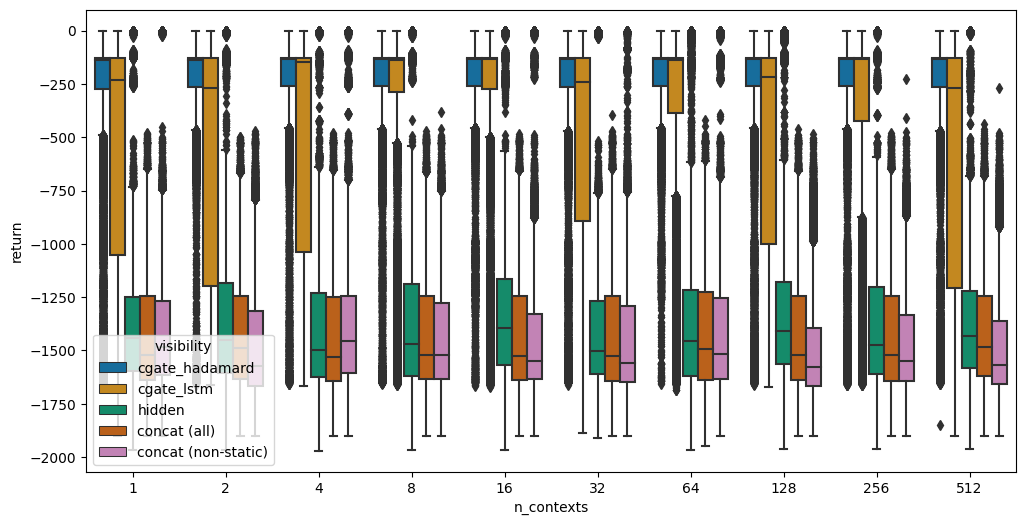

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
# ax = sns.violinplot(data=df, x="n_contexts", y="return", hue="visibility", cut=0, ax=ax)
# ax = sns.lineplot(data=df, x="n_contexts", y="return", hue="visibility", ax=ax)
ax = sns.boxplot(data=df, x="n_contexts", y="return", hue="visibility", ax=ax)
# ax.set_ylim(-500, 10)
plt.show()

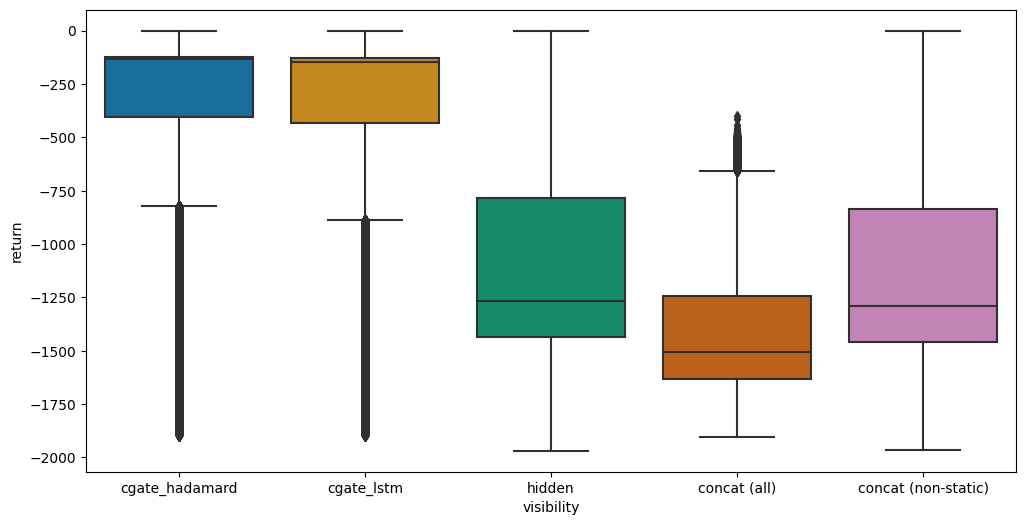

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=df, x="visibility", y="return", hue=None, ax=ax)
# ax.set_ylim(-500, 10)
plt.show()

In [9]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

filtered_df = df.copy()
# filtered_df = filtered_df[(filtered_df["seed"] != 7) & (filtered_df["seed"] != 8) & (filtered_df["seed"] != 2) & (filtered_df["seed"] != 4)]
reps = 10000
n_reps = 10  # 10 episodes per context
xlabel = ""
group_key = "visibility"

metric_names = ['Median', 'IQM', 'Mean']  # , 'Optimality Gap']
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  # metrics.aggregate_optimality_gap(x)
  ])


# Create score matrix
# Scores: (num_points x num_tasks), here:
#         (num_seeds * num_reps x num_tasks)
# Pendulum: num_tasks = n_contexts = 100
score_dict = {}
for group_id, group_df in filtered_df.groupby(group_key):
  n_seeds = group_df["seed"].nunique()
  n_context_ids = group_df["context_id"].nunique()
  print(n_seeds, n_context_ids)
  scores = np.zeros((n_seeds * n_reps, n_context_ids))
  for i, ((seed, rep), gdf) in enumerate(group_df.groupby(["seed", "rep"])):
    R = gdf["return"]
    n = len(gdf)
    index = (seed - 1) * n_seeds + rep  # seed is 1-based
    scores[i] = R
  score_dict[group_id] = scores


aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        score_dict, aggregate_func, reps=reps)


fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, aggregate_score_cis,
    metric_names=metric_names,
    algorithms=list(score_dict.keys()), xlabel=xlabel)
# fig.set_tight_layout(True)
plt.show()

10 1024


/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/astroid/node_classes.py:94: DeprecationWarning: The 'astroid.node_classes' module is deprecated and will be replaced by 'astroid.nodes' in astroid 3.0.0
  warnings.warn(


ValueError: could not broadcast input array from shape (9216,) into shape (1024,)

In [13]:
df.columns
df["context_id"].unique()

array([0])

## Test Performance on Train Contexts



$C_i = {385}$

In [4]:
folders_eval_test = [
    # "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/runs/contextefficiency_hidden/context_efficiency/CARLPendulumEnv/eval/on_train"
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/runs/context_efficiency/CARLPendulumEnv/eval/on_train"
]

reload = True
df_train = pd.concat([load(folder_eval=folder_eval, rpc_fn=f"tmp/rpc_context_efficiency_testontrain_{i}.csv", reload_rpc=reload) for i, folder_eval in enumerate(folders_eval_test)]).reset_index(drop=True)
# df_train = df_train[df["n_contexts"] < 256]
df_train["n_contexts_log"] = df_train["n_contexts"].apply(lambda x: np.log(x)/np.log(2))  # n_contexts are 1,2,4,8,16,... power of 2 

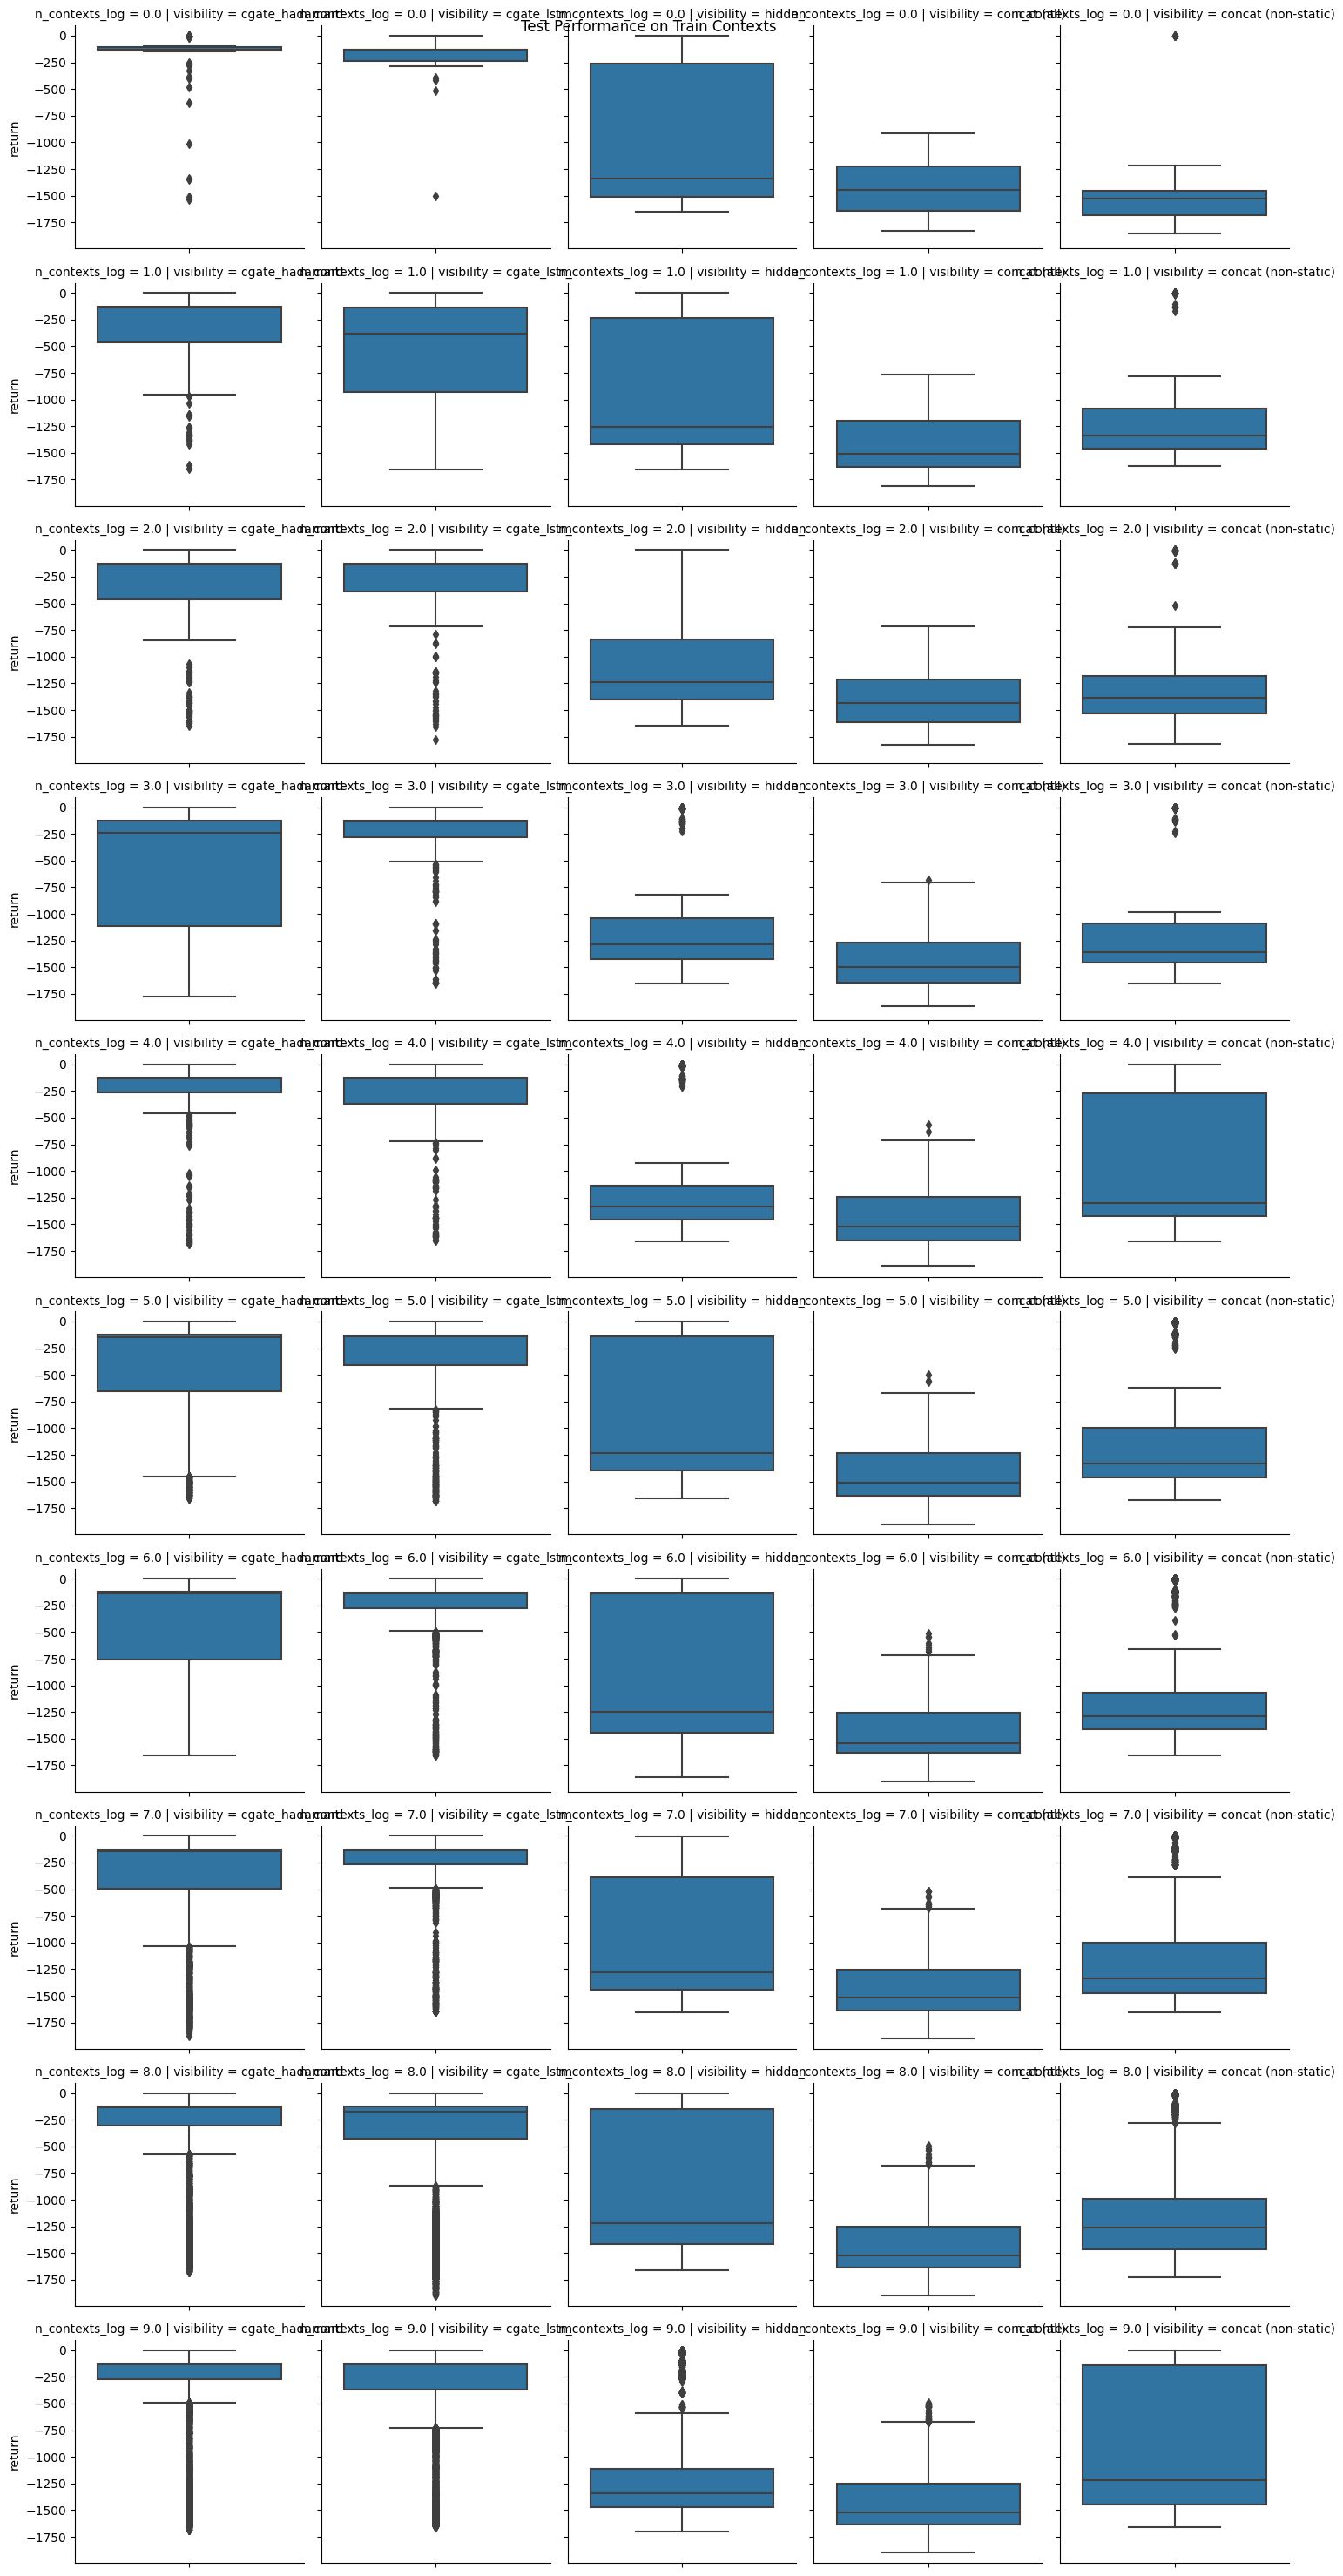

In [6]:
grid = sns.FacetGrid(data=df_train, row="n_contexts_log",  col="visibility")
grid.map_dataframe(sns.boxplot, y="return")
grid.figure.suptitle("Test Performance on Train Contexts")
grid.figure.set_tight_layout(True)
plt.show()

In [5]:
df_train[df_train["n_contexts"] == 1]["l"].unique()
grid = sns.FacetGrid(data=df_train[(df_train["n_contexts"] == 1) & (df_train["visibility"] == "hidden")], row="l")
grid.map_dataframe(sns.violinplot, y="return", cut=0)
grid.figure.suptitle("Test Performance on Train Contexts")
grid.figure.set_tight_layout(True)
plt.show()

/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/astroid/node_classes.py:94: DeprecationWarning: The 'astroid.node_classes' module is deprecated and will be replaced by 'astroid.nodes' in astroid 3.0.0
  warnings.warn(


ValueError: Image size of 300x307200 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fa5c11737f0> (for post_execute):


ValueError: Image size of 300x307200 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 300x307200 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 300x307200 with 1024 Axes>